In [1]:

#load packages
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import skimage.filters
import cv2
#import keras
#from keras.applications import vgg16
#from keras import backend as K

# Allow graph embeding in notebook
%matplotlib inline

In [2]:
#define some functions which are used in the followinig cells - please run it at least once
#downloaded code - tensorflow tutorials 
def tensor_summary(tensor):
    """Display shape, min, and max values of a tensor."""
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

    
def normalize(image):
    """Takes a tensor of 3 dimensions (height, width, colors) and normalizes it's values
    to be between 0 and 1 so it's suitable for displaying as an image."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)
    


def display_images(images, titles=None, cols=1, interpolation=None, cmap="Greys_r"):
    """
    images: A list of images. It can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15, 15* height_ratio))
    #plt.imshow(images[0])
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        
        i += 1
        
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {} {:2.0f}% (true:{})".format(i,class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
  plt.xlabel("{:.2f}  {:.2f}  {:.2f}  {:.2f}".format(predictions_array[0], predictions_array[1], predictions_array[2], predictions_array[3]))

In [3]:
#define some functions which are used in the followinig cells - please run it at least once
# the model for SqueezeNet is defined here

#import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
#np.random.seed(1) poate ar trebui decomentat ca sa fie experimentul la fel?
#tf.set_random_seed(1)
IMAGE_SIZE=192

def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

def build_model():
  x = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3]) # input is 192x192 pixels RGB

  # quick downsampling if the input image, with a strides=2 conv layer and a maxpool layer
  y = tf.keras.layers.Conv2D(kernel_size=5, filters=96, padding='same', activation='relu', strides=2)(x)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)  # output is now 48x48

  # it turns out that recognizing flowers does not require many layers
  y = fire_module(squeeze=48, expand=192)(y)
  #y = fire_module(squeeze=24, expand=64)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)

  y = fire_module(squeeze=27, expand=90)(y)
  #y = fire_module(squeeze=27, expand=90)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y) # output is 12x12x90

  #y = fire_module(squeeze=48, expand=192)(y)
  #y = fire_module(squeeze=48, expand=192)(y)
  #y = fire_module(squeeze=64, expand=256)(y)
  #y = fire_module(squeeze=64, expand=256)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=3)(y) # output is 12x12x90

  # relatively large dense layer at the end to pick up the filtered pieces and assemble them 
  #y = tf.keras.layers.Flatten()(y)  # output is 12x12x90=12960 element vector
  y = tf.keras.layers.Dropout(0.5)(y) # dropout regularization could be useful here. It also works without it but convergence is not guaranteed on every run.

  y = tf.keras.layers.Conv2D(filters=4, kernel_size=1, padding='valid', activation='relu')(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y) # output is 12x12x90
  #y = tf.keras.layers.Flatten()(y)
  y = tf.keras.layers.Dense(4, activation='softmax')(y)

  model = tf.keras.Model(x, y)
  return model

Predictions for each image (for all 4 classes): 
 [[1.2024606e-19 1.7682424e-08 1.0000000e+00 3.3486939e-19]
 [7.3569089e-01 2.6756310e-04 3.6961457e-04 2.6367190e-01]
 [5.9514612e-01 7.4993722e-02 3.2061273e-01 9.2474530e-03]]
Predicted as:  DME
Predicted as:  Normal
Predicted as:  Normal


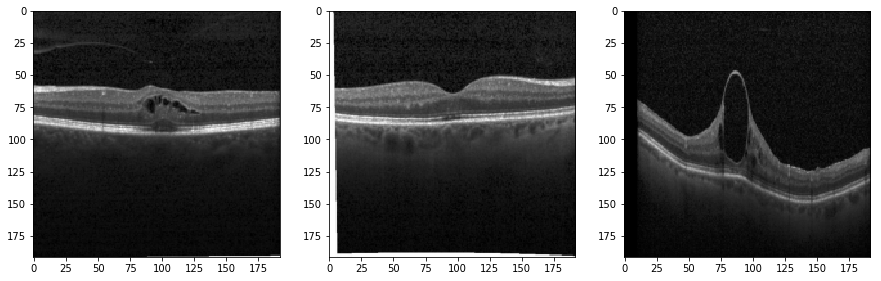

In [4]:

model=build_model()
withoutSqueezed = 0 ######## you can change the model:
                    ######## vgg (transfer knowledge model) set the value to 1;  for SqueezeNet (trained from scratch) put 0

if withoutSqueezed:
  #model2=load_model("/content/gdrive/My Drive/models/model2.h5")
  model2=load_model("/content/gdrive/My Drive/models/model_vgg_weights.48-0.21-0.21.hdf.h5")
  
  #imageSize=224
  imageSize=192
  #model_with3_trainable_true.h5'
else: 
  imageSize=192
  model=build_model()
  model.load_weights('iccp_models/1weights.034-0.15-0.9627Test0.97train.hdf5')
  model2=model


map_characters1 = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
images = [r'/home/anca/work/medical/oftalmologie/OCT2017 /test/DME/DME-3475211-1.jpeg', 
          '/home/anca/work/medical/oftalmologie/occlusionTests/normal/NORMAL-446851-1.jpeg',
           '/home/anca/work/medical/oftalmologie/occlusionTests/dme_as_normal/DME-30521-40.jpeg'] # this is wrongly predicted as normal




X=[]
for fn in images:
  img_file = cv2.imread(fn)
  img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
  img_arr = np.asarray(img_file)
  X.append(img_arr)
X = np.asarray(X)
target_names=list(map_characters1.values())

y_pred = model2.predict(X)
display_images(X, cols=3)


print('Predictions for each image (for all 4 classes): \n', y_pred)
Y_pred_classes = np.argmax(y_pred,axis = 1) 
for prediction in Y_pred_classes:
    print("Predicted as: ", target_names[prediction])




In [5]:
#apply the square patch on one of the loaded image
if withoutSqueezed:
  step = 16 #change this to different size of the box
else:
  step =16
image=X[2]


dim=0
heatmap_x = []
for row in range(0, image.shape[0], step):
    dim=dim+1
    for col in range(0, image.shape[1], step):
        new_image = image.copy()
        # Add a square patch. Using a bright color here to make it easier to see.
        new_image[row:row+step, col:col+step, :] = [0,0,0]
        heatmap_x.append(new_image)
heatmap_x = np.stack(heatmap_x)
heatmap_x.shape, dim

((144, 192, 192, 3), 12)

In [ ]:

display_images(heatmap_x, cols=dim)


In [8]:
#predict on the patched images
heatmap_y = model2.predict(heatmap_x)
tensor_summary(heatmap_y)



shape: (144, 4)  min: 2.862837440653297e-23  max: 0.9999754428863525


In [10]:
#When the prediction is different then the correct class use this:
#extract the probabilities for the right class
#label_index = 2
probs = heatmap_y[:, 0]
probs_other = heatmap_y[:, 2]  #the oct should be DME (instead of normal), so 2
probs1 = heatmap_y[:, 1]
probs2 = heatmap_y[:, 2]
probs3 = heatmap_y[:, 3]
probs0 = heatmap_y[:, 0]

#Predicted as normal instead of dme: 5.9514612e-01 7.4993722e-02 3.2061273e-01 9.2474530e-03
#probs_other = probs_other*(probs_other-0.320612 + 0.67-probs)
probs_other =   probs_other*(probs_other-0.320612)  + (1-probs)*(0.59-probs)
probs_err =   1-probs1**2 -probs2**2 -probs3**2 

In [11]:
#compute the difference
#if withoutSqueezed:
#  dim=7
#else:
#  dim=6

heatmap = (probs.max() - probs) / (probs.max()-probs.min()) #normal occlusion test
heatmap = np.reshape(heatmap, (dim, dim))

heatmap2 =  (probs_other.max() - probs_other) / (probs_other.max()-probs_other.min()) # for the real class, not the predicted one
heatmap2 = np.reshape(heatmap2, (dim, dim))

heatmap4 =   probs_other / (probs_other.max()-probs_other.min())
heatmap4 = np.reshape(heatmap2, (dim, dim))

heatmap3 =  (probs_err.max()- probs_err) / (probs_err.max()-probs_err.min())
heatmap3 = np.reshape(heatmap3, (dim, dim))

tensor_summary(heatmap)

shape: (12, 12)  min: 0.0  max: 1.0


shape: (12, 12)  min: 0.0  max: 1.0


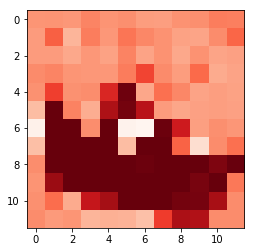

In [12]:
#show heatmap
tensor_summary(heatmap)
_ = plt.imshow(heatmap, cmap=plt.cm.Reds)



shape: (12, 12)  min: 0.0  max: 1.0


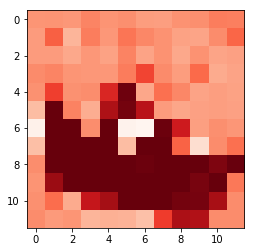

In [13]:

tensor_summary(heatmap4)
_ = plt.imshow(heatmap, cmap=plt.cm.Reds)

shape: (12, 12)  min: 0.0  max: 1.0


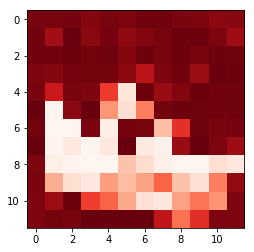

In [14]:
tensor_summary(heatmap2)
_ = plt.imshow(heatmap2, cmap=plt.cm.Reds)

shape: (192, 192, 3)  min: 0.0  max: 0.7464388299806438
Prediction of image with classical mask for occlusion test: 
 probability for normal is improved  [[9.2132038e-01 1.2049458e-02 6.5961123e-02 6.6907983e-04]]
shape: (192, 192, 3)  min: 0.0  max: 0.4531304498643386

 Prediction of image with our mask for wrongly classified: 
 probability for DME is improved (as the above part becomes more important])
  [[6.46729532e-05 1.05498955e-01 8.94432902e-01 3.56364649e-06]]


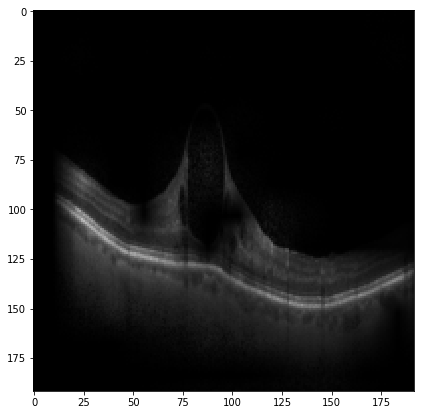

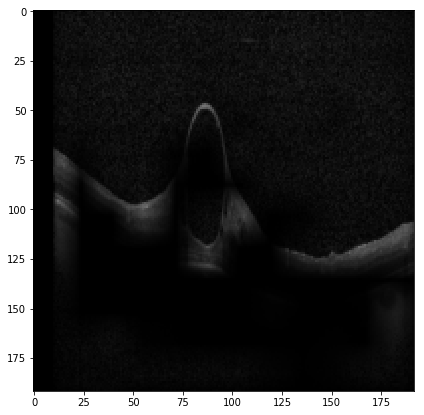

In [15]:
def apply_mask(image, mask):
    # Resize mask to match image size
    mask = skimage.transform.resize(normalize(mask), image.shape[:2])[:,:,np.newaxis].copy()
    # Apply mask to image
    image_heatmap = image * mask
    tensor_summary(image_heatmap)
    display_images([image_heatmap], cols=2)
    return image_heatmap


# Apply one of the masks to image
image_heatmap1 = apply_mask(image, (heatmap)**4)
print('Prediction of image with classical mask for occlusion test: \n probability for normal is improved ', 
            model2.predict([[image_heatmap1]]))

image_heatmap2 = apply_mask(image, (heatmap2)**4)
print('\n Prediction of image with our mask for wrongly classified: \n probability for DME is improved (as the above part becomes more important])\n ', 
         model2.predict([[image_heatmap2]]))
